In [ ]:
# !unzip "/content/drive/MyDrive/data/dog-breed-identification.zip"  -d "/content/drive/MyDrive/data/"

# Classificação de raças de cachorro
Usando TensorFlow 2.0 e TensorFlow Hub.

## 1. Definição do problema
Identificar a raça de um cachorro baseado em uma foto.

## 2. Dados
Dados da competição do Kaggle.

## 3. Métrica de avaliação
Multi Class Log Loss.
A probabilidade de ser uma raça será avaliada.

## 4. Features
- 120 raças de cachorros
- 10.000+ imagens no conjunto de treinamento (com labels)
- 10.000+ imagens no conjunto de teste (sem labels)

## Preparando o ambiente
* Importar TensorFlow
* Importar TensorFlow Hub
* Habilitar a GPU

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
print("TF version", tf.__version__)
import tensorflow_hub as hub

# Checar se a GPU está disponível
print("GPU", "disponível" if tf.config.list_physical_devices("GPU") 
                          else "indisponível")

TF version 2.7.0
GPU disponível


## Preparando o os dados
Os dados devem estar em formato numérico (especificamente, em tensores do TensorFlow)


In [ ]:
# Vendo as labels dos dados
labels_csv = pd.read_csv('/content/drive/MyDrive/data/labels.csv')
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


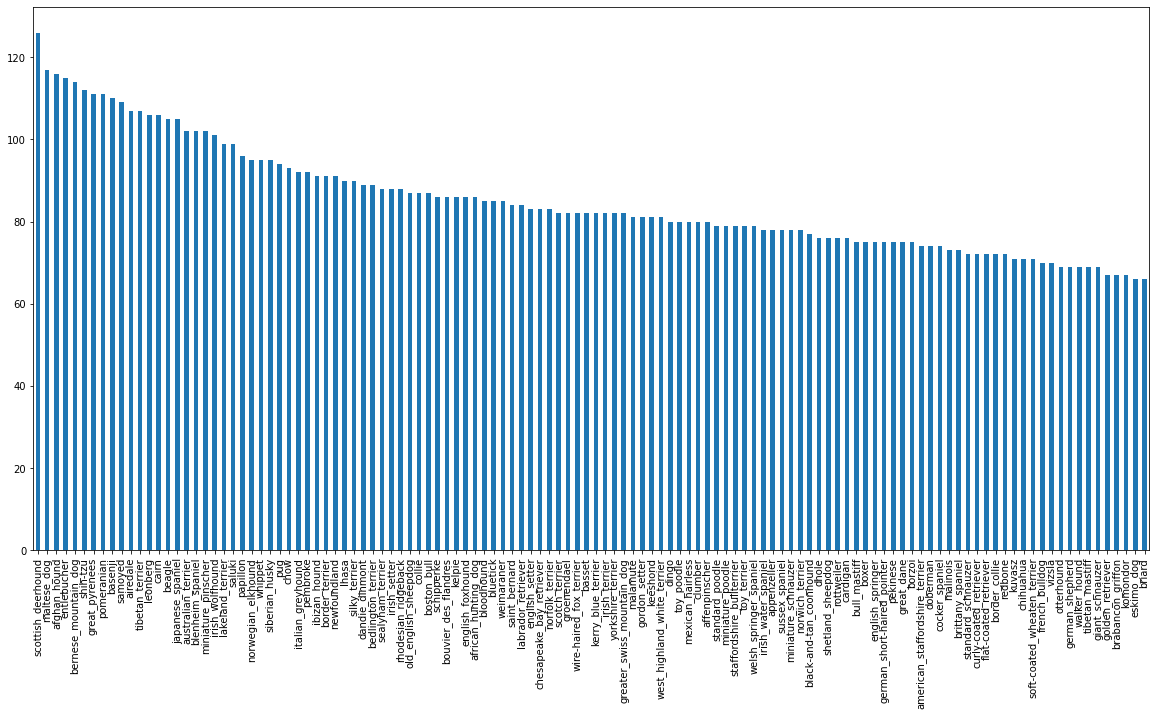

In [ ]:
labels_csv.head()
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

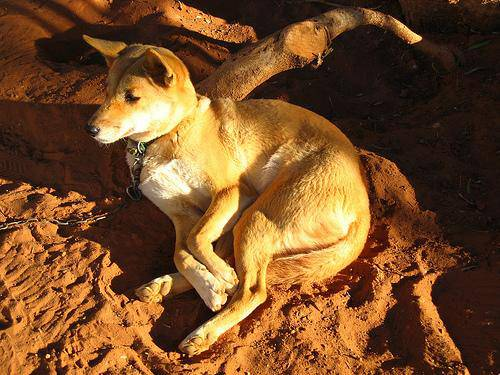

In [ ]:
from IPython.display import Image

Image("/content/drive/MyDrive/data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Obter as imagens e labels

In [ ]:
filenames = [f"/content/drive/MyDrive/data/train/{fname}.jpg" for fname in labels_csv["id"]]

In [ ]:
import os
if len(os.listdir("/content/drive/MyDrive/data/train")) == len(filenames):
  print("Match")
else:
  print("No match")

No match


In [ ]:
labels = labels_csv["breed"].to_numpy()

# checar se as labels batem com as imagens
len(labels) == len(filenames)

unique_breeds = np.unique(labels)

In [ ]:
# transformar cada label em uma array de booleans
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels)

10222

In [ ]:
# transformar arrays boolean em integers (one-hot encoding)
boolean_labels[0].astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Criar conjunto de validação

In [ ]:
X = filenames
y = boolean_labels

In [ ]:
# estabelecer número de imagens para os experimentos
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2)

In [ ]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Transformar imagens em tensores
Criar uma função que:
1. Tem um caminho como input
2. Usa TensorFlow para ler o arquivo e salvá-lo para uma variável `image`
3. Transformar a imagem em um tensor
4. Normalizar a imagem no intervalo [0-1]
5. Redimensionar a imagem para `shape(224, 224)`
6. Retornar `image` modificada

In [ ]:
# converter imagens em arrays NumPy, e depois em tensores TF
from matplotlib.pyplot import imread
image = imread(filenames[0])
tf.constant(image)

In [ ]:
# definir o tamanho das imagens
IMG_SIZE = 224

# criar a função para pré-processamento de imagens
def process_image(image_path):
  """
  A partir do caminho da imagem, transforma-a em um Tensor.
  """
  image = tf.io.read_file(image_path)
  # transformar a imagem em um tensor numérico com 3 canais de cor (R, G, B)
  image = tf.image.decode_jpeg(image, channels=3)
  # converter os valores rgb 0-255 para valores de 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # redimensionar a imagem
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

### Transformar os dados em batches
O uso de batches é necessário para evitar extrapolar o limite de memória.


